In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [2]:
conf = {
    "batch_size": 128,
    "epochs": 10,
    "learning_rate": 0.0001
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# function for parsing csv files
def parse_dataset(file):
    data_file = open(file, 'r')
    packet_data = []
    labels = []
    label_dict = {}
    try:
        firstline = data_file.readline()
        firstline.replace("\n", "")
        print(firstline)
        n_feature = 0
        for line in data_file.readlines():
            line = line.replace("\n", "")
            line = line.split(',')

            if line[1] not in label_dict:
                label_dict[line[1]] = n_feature
                n_feature += 1
            
            data = line[0].split(' ')
            data = [float(d) for d in data]
            packet_data.append(data)
            labels.append(label_dict[line[1]])

        packet_data = torch.tensor(packet_data, dtype=torch.float)
        labels = torch.tensor(labels, dtype=torch.long)
        return packet_data, labels, label_dict
    finally:
        data_file.close()

In [5]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd(), "datasets", "network_packet_data_test.csv")

data, labels, label_dict = parse_dataset(network_data_file)

packet_dat,attack_cat



In [6]:
print(data.shape)
print(labels.shape)

torch.Size([509050, 513])
torch.Size([509050])


In [7]:
def split_datasets(X, y, val_size=0.1, test_size=0.2):

    # first split: train and (val + test)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_size + test_size), random_state=42)
    train_ids, remaining_ids = next(sss1.split(X, y))

    X_train, y_train = X[train_ids], y[train_ids]
    X_remaining, y_remaining = X[remaining_ids], y[remaining_ids]

    # second split: val and test
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (val_size + test_size), random_state=42)
    val_ids, test_ids = next(sss2.split(X_remaining, y_remaining))

    X_val, y_val = X_remaining[val_ids], y_remaining[val_ids]
    X_test, y_test = X_remaining[test_ids], y_remaining[test_ids]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
X_train, X_val, X_test = X_train.unsqueeze(-1), X_val.unsqueeze(-1), X_test.unsqueeze(-1)
print(X_train.shape)
print(y_train.shape)

torch.Size([356334, 513, 1])
torch.Size([356334])


In [9]:
class NetworkDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :, :], self.labels[index]

In [10]:
# create train, val and test datasets
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

In [11]:
data, labels = next(iter(train_loader))
print(data.shape, labels.shape)

torch.Size([128, 513, 1]) torch.Size([128])


In [12]:
# create LSTM model:
class INML(nn.Module):
    def __init__(self, size):
        super(INML, self).__init__()
        self.batch = conf["batch_size"]
        self.size = size
        self.lstm = nn.LSTM(input_size=size, hidden_size=size, num_layers=2, batch_first=True, bidirectional=True, device=device)
        self.bn = nn.BatchNorm1d(2 * size)
        self.fc = nn.Linear(2*size, 24)
        
    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(4, x.shape[0], self.size).to(device)
            c0 = torch.zeros(4, x.shape[0], self.size).to(device)

        output, (h0, c0) = self.lstm(x, (h0, c0))  # output: [B, T, 2*size]

        # take last layer's hidden state (both directions)
        # h0 shape: [num_layers*2, B, size]
        h_last = h0.view(2, 2, x.shape[0], self.size)[-1]  # [2, B, size]
        h_last = torch.cat((h_last[0], h_last[1]), dim=1)  # [B, 2*size]

        # apply BN + FC
        h_last = self.bn(h_last)         # [B, 2*size] → batch norm
        out = self.fc(h_last)            # [B, 24]
        return out

In [13]:
model = INML(X_train.shape[2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

In [14]:
def evaluate(model, val_loader):
    y_true, y_pred = [], []

    model.eval()
    for (data, labels) in val_loader:
        if not data.is_cuda or not labels.is_cuda:
            data, labels = data.to(device), labels.to(device)
        
        with torch.no_grad():
            pred = model(data)
        
        y_true.append(labels)
        y_pred.append(pred)

    y_true, y_pred = torch.cat(y_true, dim=0), torch.cat(y_pred, dim=0)

    loss = criterion(y_pred, y_true)

    # evaluate accuracy

    acc = (y_pred.argmax(dim=1) == y_true).float().mean()

    return loss, acc

In [15]:
def train(model, train_loader, val_loader, epochs=conf["epochs"]):
    acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        # train model
        for (data, labels) in train_loader:
            if not data.is_cuda or not labels.is_cuda:
                data, labels = data.to(device), labels.to(device)

            pred = model(data)
            loss = criterion(pred, labels)
            running_loss += loss.item() * data.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # evaluate model
        val_loss, acc = evaluate(model, val_loader)
        train_loss = running_loss / X_train.shape[0]
        scheduler.step()

        acc_list.append(acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    
        print(f"Epoch: {epoch}/{epochs}, Accuracy: {acc:.4f}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    return acc_list, train_loss_list, val_loss_list

In [16]:
accuracy, train_loss, val_loss = train(model=model, train_loader=train_loader, val_loader=val_loader)

Epoch: 1/10, Accuracy: 0.2244, Train loss: 3.0399, Val loss: 2.7714
Epoch: 2/10, Accuracy: 0.3204, Train loss: 2.5411, Val loss: 2.3311
Epoch: 3/10, Accuracy: 0.4129, Train loss: 2.2060, Val loss: 2.0915
Epoch: 4/10, Accuracy: 0.4421, Train loss: 2.0145, Val loss: 1.9353
Epoch: 5/10, Accuracy: 0.4341, Train loss: 1.8862, Val loss: 1.8351
Epoch: 6/10, Accuracy: 0.4322, Train loss: 1.8139, Val loss: 1.7800
Epoch: 7/10, Accuracy: 0.4532, Train loss: 1.7465, Val loss: 1.7021
Epoch: 8/10, Accuracy: 0.4568, Train loss: 1.6885, Val loss: 1.6614
Epoch: 9/10, Accuracy: 0.4783, Train loss: 1.6556, Val loss: 1.6372
Epoch: 10/10, Accuracy: 0.4828, Train loss: 1.6308, Val loss: 1.6119


In [17]:
def plot_data(data, type, title, n_epochs=conf["epochs"]):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    data = [d.to('cpu') for d in data]
    plt.plot(epochs, data, marker="+", linestyle="dotted")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(type)
    plt.show()

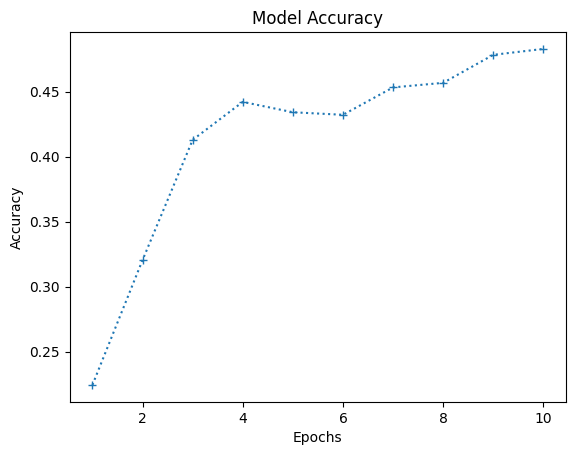

In [18]:
plot_data(accuracy, type="Accuracy", title="Model Accuracy")

In [19]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

Accuracy: 0.4820, Test loss: 1.6139


In [20]:
data, labels = next(iter(test_loader))
data = data.to(device)
pred = model(data)

print(pred[:30].argmax(dim=1))
print(labels[:30])

tensor([ 0,  5,  5,  0,  5, 10,  4,  0,  5,  5,  5, 10,  4,  5,  5,  5,  5,  0,
        10,  5,  4,  5,  0, 10,  5,  0, 10,  0,  5,  0], device='cuda:0')
tensor([ 0,  0, 14,  0, 12, 10,  5, 15, 10,  5,  5, 19, 14, 10,  4,  8,  5,  1,
         1, 19, 12,  4,  0,  3,  5,  0,  3, 11,  5,  0])
